In [1]:
%matplotlib inline
import mxnet as mx
from mxnet import gluon
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from gluonts.dataset.common import ListDataset
from datetime import datetime, timedelta
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.mx.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator
from gluonts.dataset.util import to_pandas
from gluonts.dataset.field_names import FieldName
from gluonts.model.forecast import SampleForecast
from pandas import Timestamp
import itertools
from gluonts.model.estimator import GluonEstimator
from scipy.stats import boxcox
from scipy.special import inv_boxcox

# Data Loading

In [2]:
filename='EstimatedRemainingTimeContext'

In [3]:
dataset= pd.read_csv( "Datasets//" + filename + ".csv")
X= dataset[['name','time', 'countryCode', 'ipAddress', 'level',
 'producer']]
y= dataset.iloc[:,6]
#changing the names of the attributes
gluon_dataset= pd.DataFrame()
gluon_dataset['ds'] = pd.to_datetime(X["time"])
gluon_dataset['y']=y
gluon_dataset['ds'] = gluon_dataset['ds'].dt.tz_convert(None)
gluon_dataset_copy=gluon_dataset.copy()

In [4]:
gluon_dataset_copy

ds            y
0   2021-02-18 11:31:32.752  4045.500000
1   2021-02-18 11:32:02.752  4045.500000
2   2021-02-18 11:32:32.752  4045.500000
3   2021-02-18 11:33:02.752  4153.250000
4   2021-02-18 11:33:32.752  4153.250000
..                      ...          ...
134 2021-02-18 12:38:32.752   110.500000
135 2021-02-18 12:39:02.752    60.156250
136 2021-02-18 12:39:32.752    19.140625
137 2021-02-18 12:40:02.752     5.359375
138 2021-02-18 12:40:32.752     0.765625

[139 rows x 2 columns]

In [5]:
for i in range(0,len(gluon_dataset_copy)):
    ds=gluon_dataset_copy['ds'][i]
    gluon_dataset_copy['ds'][i+1]=ds + timedelta(seconds=60)
    ds=gluon_dataset['ds'][i]
    gluon_dataset['ds'][i+1]=ds + timedelta(seconds=60)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


# Data Transformation

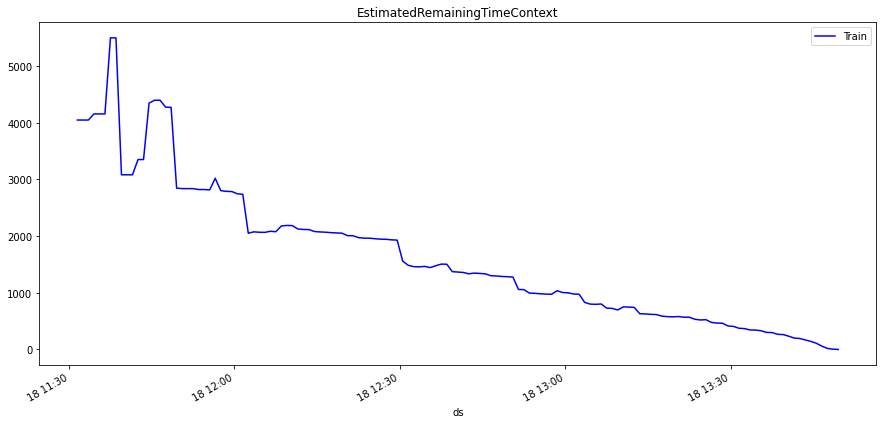

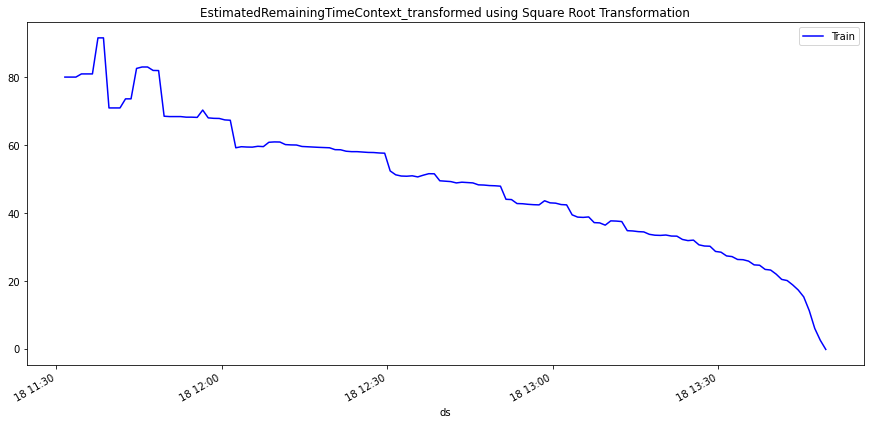

In [6]:
#Square root transformation

gluon_dataset_copy['y_orig']=gluon_dataset_copy['y']
transformed,lam = boxcox(gluon_dataset_copy['y'])
gluon_dataset_copy['y']=transformed

#plot before transformation
pd.plotting.register_matplotlib_converters()
f, ax = plt.subplots(figsize=(15,7))
gluon_dataset_copy.plot(kind='line', x='ds', y='y_orig', color='blue', label='Train', ax=ax)
plt.title(filename)
plt.show()

#plot after transformation
pd.plotting.register_matplotlib_converters()
f, ax = plt.subplots(figsize=(15,7))
gluon_dataset_copy.plot(kind='line', x='ds', y='y', color='blue', label='Train', ax=ax)
#test.plot(kind='line', x='ds', y='y', color='red', label='Test', ax=ax)
plt.title(filename + "_transformed using Square Root Transformation")
plt.show()

In [7]:
gluon_dataset_copy

ds          y       y_orig
0   2021-02-18 11:31:32.752  79.919511  4045.500000
1   2021-02-18 11:32:32.752  79.919511  4045.500000
2   2021-02-18 11:33:32.752  79.919511  4045.500000
3   2021-02-18 11:34:32.752  80.852440  4153.250000
4   2021-02-18 11:35:32.752  80.852440  4153.250000
..                      ...        ...          ...
134 2021-02-18 13:45:32.752  15.217341   110.500000
135 2021-02-18 13:46:32.752  11.187472    60.156250
136 2021-02-18 13:47:32.752   5.939754    19.140625
137 2021-02-18 13:48:32.752   2.459147     5.359375
138 2021-02-18 13:49:32.752  -0.252329     0.765625

[139 rows x 3 columns]

# Splitting Data into Training and Testing

In [8]:
gluon_dataset_copy=gluon_dataset_copy.set_index('ds')
gluon_dataset=gluon_dataset.set_index('ds')
validation_time =  "2021-02-18 12:55:32"
train_time = "2021-02-18 13:15:32"
test_time = "2021-02-18 13:49:32"
freq='1min'

In [9]:
validation_ds = ListDataset([{"start":gluon_dataset_copy.index[0], 
                         "target":gluon_dataset_copy.y[:train_time]}],
                         freq=freq
                      )
train_ds = ListDataset([{"start":gluon_dataset_copy.index[0], 
                         "target":gluon_dataset_copy.y[:validation_time]}],
                         freq=freq
                      )
test_ds = ListDataset([{"start":gluon_dataset_copy.index[0],
                        "target":gluon_dataset_copy.y[:test_time]}],
                        freq=freq
                     )
test_orig_ds = ListDataset([{"start":gluon_dataset.index[0],
                        "target":gluon_dataset.y[:test_time]}],
                        freq=freq
                     )

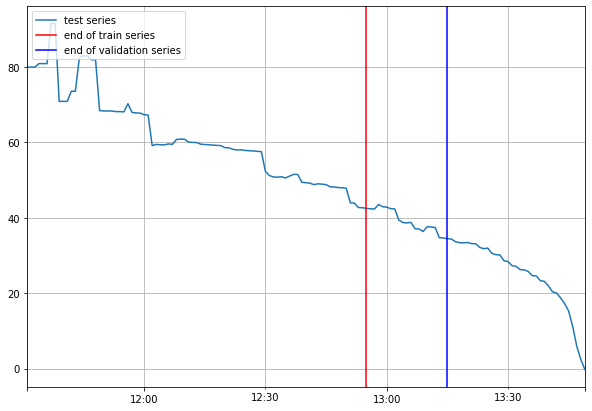

In [10]:
train_entry = next(iter(train_ds))
train_entry.keys()

validation_entry = next(iter(validation_ds))
validation_entry.keys()

test_entry = next(iter(test_ds))
test_entry.keys()

test_orig_entry = next(iter(test_orig_ds))
test_orig_entry.keys()

test_series = to_pandas(test_entry)
train_series = to_pandas(train_entry)
validation_series = to_pandas(validation_entry)

prediction_length = len(test_series) - len(validation_series)
context_length = [50,60]


list1=train_series.index
list2=train_entry['target']

d = {'ds':list1,'y':list2}
df_train=pd.DataFrame(d, columns=['ds','y'])

fig, ax = plt.subplots( figsize=(10, 7))

# train_series.plot(ax=ax[0])
# ax[0].grid(which="both")
# ax[0].legend(["train series"], loc="upper left")

test_series.plot(ax=ax)
plt.axvline(train_series.index[-1], color='r') # end of train dataset
plt.axvline(validation_series.index[-1], color='b') # end of validation dataset
ax.grid(which="both")
ax.legend(["test series", "end of train series","end of validation series"], loc="upper left")

plt.show()

In [11]:
prediction_length

34

# Hyper-parameter Tuning

In [12]:
num_hidden_dimensions = [10]
batch_size = [10,20]
epochs = [5,10]
num_batches_per_epoch = [20,30]
learning_rate = [1e-3]

In [13]:
from sklearn.model_selection import ParameterGrid

param_grid = {'num_hidden_dimensions':num_hidden_dimensions,
              'batch_size': batch_size,
              'epochs': epochs,
              'num_batches_per_epoch': num_batches_per_epoch,
              'learning_rate': learning_rate,
              'context_length': context_length
             }
grid = ParameterGrid(param_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Total Possible Models',cnt)

Total Possible Models 16


In [14]:
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
agg_metrics_all=list()
item_metrics_all=list()
for params in all_params:
    estimator = SimpleFeedForwardEstimator(
                        num_hidden_dimensions=[params['num_hidden_dimensions']],
                        prediction_length=prediction_length,
                        context_length=params['context_length'],
                        freq=freq,
                        trainer=Trainer(ctx="cpu",
                                        epochs=params['epochs'],
                                        learning_rate=params['learning_rate'],
                                        num_batches_per_epoch=params['num_batches_per_epoch']
                                       )
                )
    predictor = estimator.train(training_data = train_ds)
    forecast_it, ts_it = make_evaluation_predictions(
                            dataset=validation_ds,  # test dataset
                            predictor=predictor,  # predictor
                            num_samples=20,  # number of sample paths we want for evaluation
                         )
    forecasts = list(forecast_it)
    #print(forecasts)
    tss = list(ts_it)
    evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
    agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))
    agg_metrics['num_hidden_dimensions'] = params['num_hidden_dimensions']
    agg_metrics['epochs'] = params['epochs']
    agg_metrics['learning_rate'] = params['learning_rate']
    agg_metrics['num_batches_per_epoch'] = params['num_batches_per_epoch']
    agg_metrics['context_length'] = params['context_length']
    agg_metrics['forecast'] = forecasts
    agg_metrics_all.append(agg_metrics)
    item_metrics_all.append(item_metrics)
    
dataframe = pd.DataFrame(agg_metrics_all)
print(dataframe)
sorted1 = dataframe.sort_values(by=['MAPE'])
sorted1 = sorted1.reset_index(drop=True)

  0%|          | 0/20 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/20 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/30 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/30 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/20 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/20 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/30 [00:00<?, ?it/s]WARNING:gluonts.trainer:Batch [1] of Epoch[0] gave NaN loss and it will be ignored


learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/30 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/20 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/20 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/30 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/30 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/20 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/20 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/30 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/30 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  9.77it/s]


           MSE   abs_error  abs_target_sum  abs_target_mean  seasonal_error  \
0     7.724440   81.824005     1431.758301        42.110538        1.261681   
1   552.818589  670.200867     1431.758301        42.110538        1.261681   
2     8.419187   77.603096     1431.758301        42.110538        1.261681   
3   295.771973  457.458008     1431.758301        42.110538        1.261681   
4    14.681300  110.971100     1431.758301        42.110538        1.261681   
5   429.055406  607.989075     1431.758301        42.110538        1.261681   
6     6.120200   65.900444     1431.758301        42.110538        1.261681   
7   235.301054  386.856293     1431.758301        42.110538        1.261681   
8     9.916224   80.427605     1431.758301        42.110538        1.261681   
9   344.169204  542.688416     1431.758301        42.110538        1.261681   
10    6.753123   67.020767     1431.758301        42.110538        1.261681   
11  204.218276  401.104614     1431.758301        42

# Forecast and Evaluation

In [15]:
estimator = SimpleFeedForwardEstimator(
    num_hidden_dimensions=[sorted1['num_hidden_dimensions'][0]],
    prediction_length=prediction_length,
    context_length=sorted1['context_length'][0],
    freq=freq,
    trainer=Trainer(ctx="cpu",
                    epochs=sorted1['epochs'][0],
                    learning_rate=learning_rate[0],
                    num_batches_per_epoch=sorted1['num_batches_per_epoch'][0]
                   )
)

In [16]:
predictor = estimator.train(train_ds)

  0%|          | 0/30 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 30/30 [00:00<00:00, 146.80it/s, epoch=5/5, avg_epoch_loss=3.31]


In [17]:
# estimator1= GluonEstimator(trainer=Trainer(ctx="cpu",
#                     epochs=5,
#                     learning_rate=1e-3,
#                     hybridize=False,
#                     num_batches_per_epoch=100
#                    ))


In [18]:
# estimator2 = SimpleFeedForwardEstimator(
#     num_hidden_dimensions=[5],
#     prediction_length=prediction_length,
#     context_length=context_length,
#     freq=freq,
#     trainer=Trainer(ctx="cpu",
#                     epochs=5,
#                     learning_rate=1e-3,
#                     #hybridize=False,
#                     num_batches_per_epoch=5
#                    )
# )

In [19]:
# estimator1.train(training_data = train_ds, validation_data = validation_ds)

In [20]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

forecasts = list(forecast_it)
tss = list(ts_it)
ts_entry = tss[0]
forecast_entry = forecasts[0]

forecasts_val=sorted1['forecast'][0]
forecast_entry_val = forecasts_val[0]



In [21]:
#return forecast to original
#inv = np.vectorize(log_inverse_transformation)

forecast_entry.samples = inv_boxcox(forecast_entry.samples,lam)
forecast_entry_inv=SampleForecast(freq=freq, start_date=forecast_entry.start_date, samples=forecast_entry.samples)

forecast_entry_val.samples = inv_boxcox(forecast_entry_val.samples,lam)
forecast_entry_val_inv=SampleForecast(freq=freq, start_date=forecast_entry_val.start_date, samples=forecast_entry_val.samples)

ts_entry_inv=inv_boxcox(ts_entry,lam)
ts_entry_inv_df=pd.DataFrame(ts_entry_inv, index=ts_entry.index)
tss_inv=list()
tss_inv.append(ts_entry_inv_df)

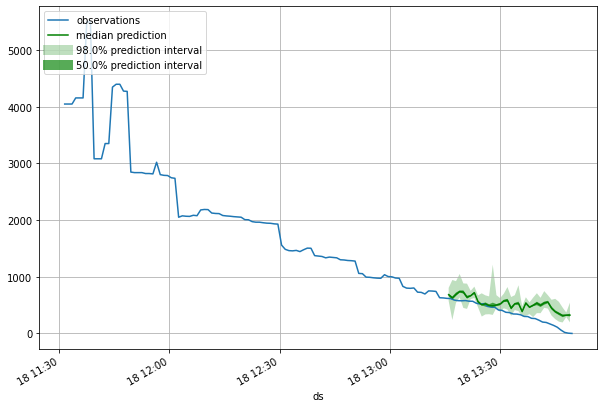

In [22]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 200
    prediction_intervals = (50.0,98.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()
plot_prob_forecasts(gluon_dataset['y'], forecast_entry_inv)

In [23]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss_inv), iter([forecast_entry_inv]), num_series=len(test_ds))


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  9.14it/s]


In [24]:
agg_metrics

{'MSE': 43925.518382352944,
 'abs_error': 6014.85791015625,
 'abs_target_sum': 11907.296875,
 'abs_target_mean': 350.21461397058823,
 'seasonal_error': 96.93839205228366,
 'MASE': 1.824948628170105,
 'MAPE': 15.287956274972016,
 'sMAPE': 0.5586029600229301,
 'OWA': nan,
 'MSIS': 40.54685920970182,
 'QuantileLoss[0.1]': 8051.778353881836,
 'Coverage[0.1]': 0.7941176470588235,
 'QuantileLoss[0.5]': 6014.857696533203,
 'Coverage[0.5]': 0.9705882352941176,
 'QuantileLoss[0.9]': 1566.9924987792965,
 'Coverage[0.9]': 1.0,
 'RMSE': 209.58415584760442,
 'NRMSE': 0.5984449177360878,
 'ND': 0.5051405010976725,
 'wQuantileLoss[0.1]': 0.676205392240364,
 'wQuantileLoss[0.5]': 0.5051404831571568,
 'wQuantileLoss[0.9]': 0.13159934746141083,
 'mean_absolute_QuantileLoss': 5211.209516398112,
 'mean_wQuantileLoss': 0.43764840761964385,
 'MAE_Coverage': 0.4215686274509804}

# Residual

In [25]:
#get the mean for all the samples
f1 = forecast_entry_val_inv.samples.mean(axis=0)
f2 = forecast_entry_inv.samples.mean(axis=0)

In [26]:
original_values=list(gluon_dataset['y'])
orig_test = original_values[:len(original_values)-prediction_length]
test_extract=original_values[-prediction_length:]
val_extract=orig_test[-prediction_length:]

In [27]:
valandtest_orig=list()
valandtest_pred=list()
for a1 in val_extract:
    valandtest_orig.append(a1)

for b1 in test_extract:
    valandtest_orig.append(b1)
    
for a2 in f1:
    valandtest_pred.append(a2)

for b2 in f2:
    valandtest_pred.append(b2)


Text(0.5, 1.0, 'Residuals')

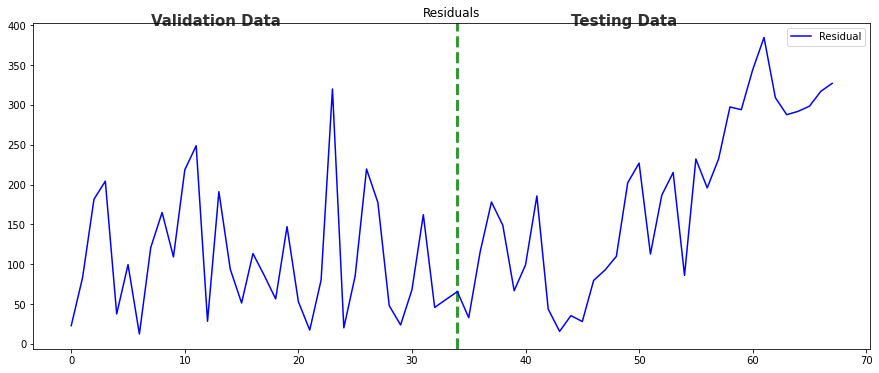

In [28]:
residuals = abs(np.array(valandtest_pred)-np.array(valandtest_orig))
residuals_df=pd.DataFrame()
residuals_df['residuals']=residuals
#residuals_df['ds']=prophet_dataset2['ds']

f, ax = plt.subplots(figsize=(15,7))
ax.text(x=len(val_extract)/2 -10,y=400, s='Validation Data', color='black', fontsize=15, fontweight='bold', alpha=0.8)
ax.text(x=len(val_extract)+10,y=400, s='Testing Data', color='black', fontsize=15, fontweight='bold', alpha=0.8)
ax.axvline(x=len(val_extract), c='green', lw=3, alpha=0.8, ls='--')
residuals_df.plot(kind='line',  y='residuals', color='blue', label='Residual',figsize=(15, 6),ax=ax)
plt.title("Residuals")

# Saving the Model

In [30]:
import pickle
import datetime
with open('Genome_Models/' + filename + '_'+ datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S") + '.pkl', 'wb') as fout:
     pickle.dump(predictor, fout)

AttributeError: Can't pickle local object 'SimpleFeedForwardNetworkBase.__init__.<locals>.<lambda>'